# Introduction

This file first aims to compare different (basic) constraints in portfolio optimisaion, based on their performances: allocation diversity, return, Sharpe ratio. We will focus on the long-only, L/S and leverage constaints with a simple MV optimisation problem. 

Secondly, viewing the poor diversity of the allocations, we add a risk aversion parameter to the Markowitz problem simuation. We find the best value of it over the first semester of 2025.

The basket of assets we use is the CAC40 (the top 40 french firms with biggest capitalisation).

### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cvx

# Data loading and preparation

In [2]:
# cac40.csv contains adjusted close prices from 2022 Jan to 2025 June 
cac40 = pd.read_csv('cac40.csv',index_col="Date")
tickers = cac40.columns
returns = cac40.pct_change().dropna()
T,N = returns.shape


# In sample - 2022 Jan to 2024 Dec.
returns_insample = returns.loc[:'2025-01-01']
T_in,_ = returns_insample.shape
print(f'# of in sample values : {T_in}')


# Out of sample - two first quarters of 2025
returns_outsample = returns.loc['2025-01-01':]
T_out,_ = returns_outsample.shape

# of in sample values : 438


# Problems optimisation

We approximate the mean of the return by the sample mean, assuming $N_{in} = 438$ is high enough. Similarly, we approximate the covariance matrix by the sample one.

Then we compute the solution of the Markowitz formulation: 

$\quad\min_{w} w^T\Sigma w - \mu^T w $

For three different constraints: 
- Long-only: $w^T1=1$ and $w>=0$
- Long/Short: $w^T1=1$
- Long/Short with leverage constraint: $w^T1=1$ and $\|w\|_1\leq 2$

In [3]:
# Comute mean and vairance
mu = returns_insample.mean().to_numpy()
Sigma = returns_insample.cov().to_numpy()

# Long-only 
w_lo = cvx.Variable(N)
objective = cvx.Minimize(cvx.quad_form(w_lo,Sigma) - w_lo.T@mu)
constraints = [ w_lo >= 0 , cvx.sum(w_lo) == 1]
long_only_pb = cvx.Problem(objective,constraints)
long_only_pb.solve()

# Long/Short, no levrage constaint
w_ls = cvx.Variable(N)
objective = cvx.Minimize(cvx.quad_form(w_ls,Sigma) - w_ls.T@mu)
constraints = [ cvx.sum(w_ls) == 1]
long_short_pb = cvx.Problem(objective,constraints)
long_short_pb.solve()

# Long-Short, leverage fixed at 2
w_l2 = cvx.Variable(N)
objective = cvx.Minimize(cvx.quad_form(w_l2,Sigma) - w_l2.T@mu)
constraints = [ cvx.sum(w_l2) == 1, cvx.norm1(w_l2) <= 2]
leverage_pb = cvx.Problem(objective,constraints)
leverage_pb.solve()

# Results 
col_names = ["Long-only","Long/Short","Leverage-limited"]
weights = np.array([w_lo.value,w_ls.value,w_l2.value]).T
weights= np.round(weights,5)

# Portfolios comparison

First let's take a glance at the different allocations

In [4]:
results = pd.DataFrame(weights,index=tickers,columns=col_names)
results.mask(results.abs()<1e-5,0)

,Long-only,Long/Short,Leverage-limited
AC.PA,0.0,2.90052,0.13730
ACA.PA,0.0,2.97750,0.00000
AI.PA,0.0,-1.34767,0.00000
AIR.PA,0.0,0.51380,0.00000
BN.PA,0.0,5.12571,0.00000
BNP.PA,0.0,-0.77821,0.00000
BVI.PA,0.0,-1.15916,0.00000
CA.PA,0.0,-1.59718,0.00000
CAP.PA,0.0,1.16410,0.00000
CS.PA,0.0,0.72407,0.00000


First observation: the long-only portfolio contains only one stock and the L/S one took position for every single stock!

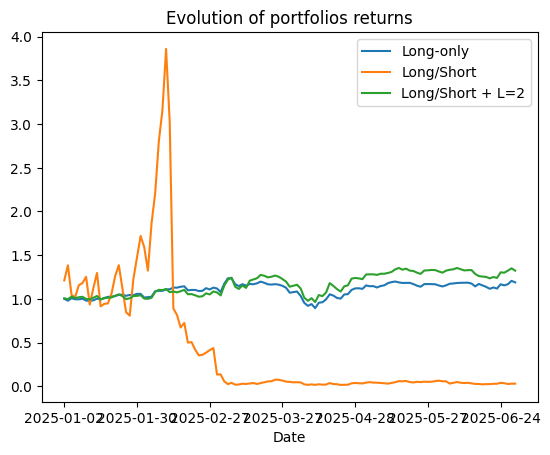

In [5]:
# Return performances
return_lo = returns_outsample@w_lo.value
p_lo = (1+return_lo).cumprod()                     # p stands for portfolio
p_lo.plot(label='Long-only')

return_ls = returns_outsample@w_ls.value
p_ls = (1+return_ls).cumprod()
p_ls.plot(label='Long/Short')

return_l2 = returns_outsample@w_l2.value
p_l2 = (1+return_l2).cumprod()
p_l2.plot(label='Long/Short + L=2')

plt.legend()
plt.title('Evolution of portfolios returns')
plt.show()

Everyone can see that the L/S portfolio without any leverage constaint performs terribly. By looking in details in the computed weights, we found out that some risky short positions have been taken, that finally turned out badly. We can cite Danone (DG.PA) and Legrand SA (LR.PA) weighted respectively at -456% and -393%. 

Let's drop the L/S portfolio without leverage constraint and compare more attentively the two remaining allocations.

In [6]:
# Allocation
print('--- Portolio Allocation --- ')
allocation = results[(results[["Long-only","Leverage-limited"]]!=0).any(axis=1)]

print(allocation[["Long-only","Leverage-limited"]])

--- Portolio Allocation --- 
        Long-only  Leverage-limited
AC.PA        -0.0           0.13730
KER.PA        0.0          -0.43991
SAF.PA       -0.0           0.01666
SGO.PA        1.0           1.26015
SU.PA         0.0           0.08589
TEP.PA        0.0          -0.06009


In [7]:
# Exact return after one semester 
final_return_lo = np.round(p_lo.iloc[-1],2)
final_return_l2 = np.round(p_l2.iloc[-1],2)

print('\n--- Final Returns ---')
print(f'Long-Only : {final_return_lo}')
print(f'Long/Short (leverage-limited) : {final_return_l2}')


--- Final Returns ---
Long-Only : 1.19
Long/Short (leverage-limited) : 1.32


In [8]:
# Sharpe Ratio 
r_f = 0.024                     # Livret A (French savings account) returns for Q1 and Q2 of 2025

annualised_return_lo = 252*return_lo.mean()
annualised_std_lo = np.sqrt(252)*return_lo.std()
SR_lo = (annualised_return_lo - r_f)/annualised_std_lo

annualised_return_l2 = 252*return_l2.mean()
annualised_std_l2 = np.sqrt(252)*return_l2.std()
SR_l2 = (annualised_return_l2 - r_f)/annualised_std_l2

print('\n--- Sharpe Ratios ---')
print(f'Long-Only : {np.round(SR_lo,2)}')
print(f'Long/Short (leverage-limited) : {np.round(SR_l2,2)}')


--- Sharpe Ratios ---
Long-Only : 1.04
Long/Short (leverage-limited) : 1.37


The long-only consists in only one stock, Saint-Gobain (SGO.PA), and the leverage-limited one has only 6 stocks. Hence the conclusion is that they are both very risky from a diversification point of view. Indeed, 4 among those 6 are in the the sector fo Industiral according to GICS.

Although they are risky, these portfolios are very effective, having 19% and 32% in returns during one semester. Finally, we compute their sharpe ratio using the french saving account (fixed at an annualised interest rate of 2.4% during 2025 first semester). We got 1.04 for the long-only portfolio, which is pretty decent recalling the fact it consists in only one stock, and 1.37 for the leverage-limited portfolio, which is a good value. 

Finally, the Long/Short leverage-limited portfolio is a first step toward a portfolio fixed allocation. A dynamic allocation will be the topic of another latter file. For instance, we will try to diversify this portfolio by balancing the mean and variance in the optimisation problem. To that end, we add a risk aversion parameter $\lambda > 0$ and we try to find its best value.

# Diversification using risk aversion

## Step 0 - where to go?

If only a few stocks are picked, two options : either they have a high return or a low volatility. To find out in which side we should balance the MV problem, let's look at the Saint-Gobin (SGO - the only stock selected in the long-only optimisation) return and variance compared to the market, approximated by the mean of all the stocks in CAC40.

In [9]:
# For the returns
print(f'Average return: {mu.mean()}, SGO return: {mu[-8]}')
# We use .trace()/N instead of .mean() to not consider covarances
print(f'Average vol: {Sigma.trace()/N}, SGO vol: {Sigma[-8,-8]}')

Average return: 0.00017553865936111512, SGO return: 0.0014088177685374877
Average vol: 0.00022432088225889904, SGO vol: 0.00021026069088327977


One can see that SGO return is almost ten times higher than the average, whereas the volatility (variance) is very similar to the market. This allows to claim that return are overweighted in the problem formulation. Therefore, we search $\lambda>1$ in a problem formulation such as:

$\quad\min_{w} \lambda w^T\Sigma w - \mu^T w $

to balance the returns.

## Optimisation for different $\lambda$

In [10]:
# Lambda tweaking
lambdas = [1,2,4,6,8,10,12,14,16,18,20]              # We stop at lambda = 10 because r_SGO ~ 10*r_mean
portfolios = pd.DataFrame(index=tickers,columns=lambdas)
w = cvx.Variable(N)
constraints = [ cvx.sum(w) == 1, cvx.norm1(w) <= 2]
for l in lambdas : 
    objective = cvx.Minimize(l*cvx.quad_form(w,Sigma) - mu.T@w)
    problem = cvx.Problem(objective,constraints)
    problem.solve()
    portfolios[l] = np.round(w.value,5)

portfolios.mask(portfolios.abs()<1e-5,0)


,1,2,4,6,8,10,12,14,16,18,20
AC.PA,0.13730,0.31952,0.29417,0.25349,0.22652,0.21049,0.19967,0.18532,0.17224,0.16188,0.15362
ACA.PA,0.00000,0.00000,0.06645,0.11433,0.12591,0.13304,0.13781,0.14044,0.13845,0.13788,0.13745
AI.PA,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00001
AIR.PA,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00001
BN.PA,0.00000,0.00000,0.00000,0.11607,0.20291,0.25940,0.29701,0.32017,0.32475,0.31838,0.31330
BNP.PA,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00001
BVI.PA,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00001
CA.PA,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00001
CAP.PA,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
CS.PA,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00001


## Comparison of the perfomances

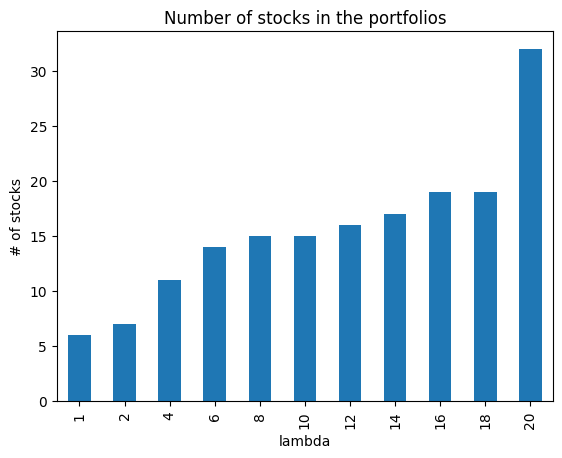

In [11]:
# Number of stocks in the portfolio
(portfolios!=0).sum().plot(kind='bar')
plt.title('Number of stocks in the portfolios')
plt.xlabel('lambda')
plt.ylabel('# of stocks')
plt.show()

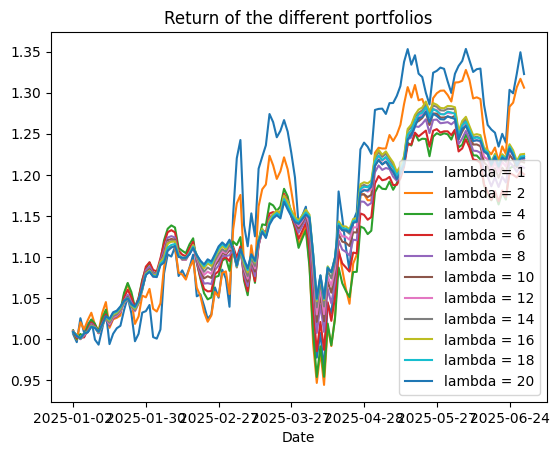

In [12]:
# Returns comparison 
portfolios_returns = {}
portfolios_evolution = {}
for l in lambdas:
    portfolios_returns[l]  = returns_outsample@portfolios[l]
    evolution = (1+portfolios_returns[l]).cumprod()
    evolution.plot(label=f'lambda = {l}')
    portfolios_evolution[l] = evolution
plt.legend()
plt.title('Return of the different portfolios')
plt.show()

In [13]:
# Final return 
print('--- Final returns ---')
for l in lambdas :
    r = np.round(portfolios_evolution[l].iloc[-1],3)
    print(f'lambda = {l} - return: {r}')

--- Final returns ---
lambda = 1 - return: 1.323
lambda = 2 - return: 1.306
lambda = 4 - return: 1.218
lambda = 6 - return: 1.201
lambda = 8 - return: 1.208
lambda = 10 - return: 1.215
lambda = 12 - return: 1.219
lambda = 14 - return: 1.222
lambda = 16 - return: 1.225
lambda = 18 - return: 1.223
lambda = 20 - return: 1.221


In [14]:
# Sharpe Ratios 
print('\n--- Sharpe Ratios ---')
for l in lambdas :
    r_p = portfolios_returns[l]
    annualised_return = 252*r_p.mean()
    annualised_std = np.sqrt(252)*r_p.std()
    SR = (annualised_return - r_f)/annualised_std           # r_f is still 2.4% as previously
    print(f'lambda = {l} - SR: {np.round(SR,2)}')
    


--- Sharpe Ratios ---
lambda = 1 - SR: 1.37
lambda = 2 - SR: 1.45
lambda = 4 - SR: 1.32
lambda = 6 - SR: 1.4
lambda = 8 - SR: 1.58
lambda = 10 - SR: 1.72
lambda = 12 - SR: 1.82
lambda = 14 - SR: 1.9
lambda = 16 - SR: 2.0
lambda = 18 - SR: 2.08
lambda = 20 - SR: 2.15


At this point, here is what we can conclude: 
- The number of stocks in the portfolio increases, as expected, with the rise of $\lambda$. The volatility was indeed underweighted. 
- According to the evolution of the return, one can see that portfolios with $\lambda =1$ and $2$ are more volatil than the others. Starting from $\lambda = 3$, the greater is $\lambda$ the better the portfolio resist to a 'crisis' or market downturns. This means the volatility drops and the portfolio is less risky. 
- Starting from $\lambda= 6$ the return of the portfolio increases with diversifiaction. The best return (for $\lambda > 2$) is reached at $\lambda = 16$.
- The sharpe ratio has a very good value for $\lambda = 8$ and above. It is still rising at $\lambda = 20$.

Thus, the best value for $\lambda$ seems to be $16$, guaranteeing a high return while managing volatility. Here is its composition:

In [15]:
# Best allocation
best_portfolio = portfolios[16]
best_allocation = best_portfolio[best_portfolio!=0]
best_allocation

AC.PA       0.17224
ACA.PA      0.13845
BN.PA       0.32475
DG.PA      -0.00923
EDEN.PA    -0.07133
EL.PA       0.13893
ENGI.PA     0.15210
KER.PA     -0.13755
ML.PA       0.03115
ORA.PA      0.02156
PUB.PA      0.13826
RI.PA      -0.10382
RMS.PA      0.04113
SAF.PA      0.05427
SGO.PA      0.10759
STMPA.PA   -0.11002
SU.PA       0.08669
TEP.PA     -0.06804
URW.PA      0.09290
Name: 16, dtype: float64

Remark : Of course, we should have done the $\lambda$ selection over the in-sample data, and to verify it over the out-of-sample. Here the objective was just to implement the tool to do it.